If you are interested in graident boosting, here is a good place to start: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

This is a supervised machine learning method.

# Predicting PorPerm - Perm

In [ ]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.3.3)


In [ ]:
# If you have installation questions, please reach out

import pandas as pd # data storage
import xgboost      # graident boosting 
import numpy as np  # math and stuff

import datetime
import seaborn as sns
import scipy.stats as stats

import xgboost as xgb

import sklearn  
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.metrics import median_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, max_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt # plotting utility

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner_imputed_12_21_2020.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.468406,0.325999,0.430844,0.811259,0.613371,0.351642,1.011018,0.172737,0.172737,0.351702,0.326029,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.191316,0.237404,0.263514,0.162843,0.214604,0.186912,1.503608,0.226664,0.226664,0.178735,0.229901,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.360072,0.122318,0.174146,0.743878,0.424460,0.216157,-0.037336,0.004595,0.004595,0.220800,0.131058,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.554827,0.275825,0.471657,0.867010,0.605516,0.329327,0.795008,0.005532,0.005532,0.337049,0.283192,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602566,0.530980,0.662807,0.925012,0.830179,0.470706,1.378387,0.332503,0.332503,0.463317,0.525448,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

In [ ]:
df = df[df.perm_klink_md >= 0]
df = df[df.USGS_ID != 'E997'] # removing E997

In [ ]:
df.USGS_ID.unique()

array(['E952', 'E945', 'E974', 'F041', 'F042', 'CEPO', 'S179', 'PDRMT'],
      dtype=object)

In [ ]:
df.describe()

,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,0.0,0.0,0.0,0.0,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.0,266.000000,2.660000e+02,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,11005.040056,0.288960,0.168871,0.244626,0.733233,0.757969,0.216900,1.756052,0.377054,0.377054,0.218456,0.168123,3.778635,3.774693,0.054289,0.029445,8.353501,NaN,NaN,NaN,NaN,1.225129,0.023595,0.249668,0.008572,2.880668,0.011135,38.562358,0.034262,0.040629,0.001759,0.228559,0.001334,0.970694,0.004292,1.400665,0.003524,0.123235,0.001153,0.005938,0.000140,0.005078,0.000646,0.903334,0.002148,0.000676,0.0,0.004594,1.000000e-04,0.000249,0.000733,0.002891,0.000725,0.097998,0.004588
std,1815.527198,0.176993,0.190307,0.157285,0.177795,0.173340,0.180242,2.299386,0.152922,0.152922,0.170656,0.176120,0.766081,0.778546,0.049054,0.032283,1.919978,NaN,NaN,NaN,NaN,0.336102,0.002730,0.170741,0.001184,0.831223,0.001496,3.159481,0.001703,0.016345,0.000206,0.136984,0.000400,0.429752,0.000819,1.962939,0.001884,0.044275,0.000146,0.002379,0.000059,0.009504,0.000079,0.576382,0.000575,0.000345,0.0,0.000465,4.073422e-19,0.001426,0.000059,0.002063,0.000067,0.072391,0.000431
min,9344.500000,0.026503,0.000000,0.026835,0.185083,0.002306,0.000098,-0.731287,0.107903,0.107903,0.004730,0.001807,2.684500,2.664900,0.001000,0.001000,1.000000,NaN,NaN,NaN,NaN,0.409700,0.016000,0.078000,0.007000,1.094000,0.007600,24.356200,0.027700,0.014100,0.001300,0.040300,0.000700,0.265000,0.002500,0.148400,0.001600,0.050000,0.000900,0.000000,-0.000300,0.000000,0.000500,0.272300,0.001300,0.000300,0.0,0.003300,1.000000e-04,0.000000,0.000600,0.000000,0.000500,0.013700,0.003700
25%,9428.000000,0.070273,0.047672,0.071584,0.643118,0.655566,0.091385,-0.039922,0.240092,0.240092,0.085650,0.056812,3.468600,3.467900,0.028000,0.013000,7.800000,NaN,NaN,NaN,NaN,1.040675,0.022625,0.149100,0.007800,2.603575,0.010625,38.186825,0.033900,0.029500,0.001600,0.137250,0.001000,0.771550,0.003900,0.490650,0.002500,0.101200,0.001100,0.004425,0.000100,0.000000,0.000600,0.651575,0.001900,0.000500,0.0,0.004300,1.000000e-04,0.000000,0.000700,0.001425,0.000700,0.054900,0.004300
50%,10248.500000,0.321846,0.085192,0.236906,0.775423,0.823719,0.182213,1.105795,0.385679,0.385679,0.185589,0.089402,3.709800,3.702248,0.052000,0.029000,8.900000,NaN,NaN,NaN,NaN,1.326400,0.024200,0.195000,0.008250,2.930400,0.011300,39.479350,0.034700,0.037200,0.001700,0.181600,0.001200,0.969100,0.004350,0.695150,0.002900,0.117900,0.001100,0.005350,0.000100,0.000900,0.000600,0.796700,0.002100,0.000600,0.0,0.004600,1.000000e-04,0.000000,0.000700,0.002400,0.000700,0.074500,0.004500
75%,13349.600000,0.413325,0.206563,0.344660,0.880824,0.846856,0.260953,2.468503,0.459753,0.459753,0.269907,0.198776,3.855600,3.851400,0.068000,0.039000,9.600000,NaN,NaN,NaN,NaN,1.455175,0.025200,0.281575,0.008900,3.141550,0.011700,40.078400,0.035300,0.047200,0.001800,0.284175,0.001500,1.104050,0.004600,1.089075,0.003500,0.137650,0.001200,0.006700,0.000200,0.005075,0.000700,0.955025,0.002300,0.000700,0.0,0.004800,1.000000e-04,0.000000,0.000800,0.003900,0.000700,0.111775,0.004800
max,13584.000000,0.562989,0.911408,0.792190,0.930279,0.954558,0.934521,8.924409,0.998360,0.998360,0.881915,0.826759,7.589500,7.589500,0.517000,0.370000,11.800000,Na

## Loading in dataset

In [ ]:
dataset = df[[
    #'depth_ft', 
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
       'RESD', 'PHIN', 'PHID', 
       'GR_smooth', 
       'PE_smooth',
       'perm_klink_md'
]]

In the next code block, we will remove the rows without data, and change string NaN's to np.nans

In [ ]:
dataset.replace('NaN',np.nan, regex=True, inplace=True)# 
#dataset = dataset.dropna()
np.shape(dataset)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


(357, 12)

In [ ]:
dataset.head(3)

,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,perm_klink_md
1229,0.554827,0.106534,0.062840,0.428129,0.640543,0.142615,7.794016,0.443457,0.443457,0.079817,0.168882,0.025
1240,0.554827,0.112556,0.056922,0.438185,0.655566,0.218843,7.794016,0.385185,0.385185,0.094562,0.190306,0.040
1250,0.554827,0.066613,0.062503,0.451586,0.640814,0.223560,7.066365,0.430617,0.430617,0.102731,0.196158,0.038


In [ ]:
X = dataset[[ 'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

Y = dataset[['perm_klink_md']]

Y_array = np.array(Y.values)

## Starting to set up the ML model params

In [ ]:
seed = 7 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

### Let's try some hyperparameter tuning (this takes forever!)

Hyperparameter testing does a grid search to find the best parameters, out of the parameters below. This turned out to be really slow on my laptop. Please skip this! 

In [ ]:
xg_reg = xgb.XGBRegressor()

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("Mean Squared Error: %f" % (rmse))
max = max_error(y_test, preds)
print("Max Error: %f" % (max))

MAE = median_absolute_error(y_test, preds)
print("Median Abs Error: %f" % (MAE))

Mean Squared Error: 0.018404
Max Error: 0.074537
Median Abs Error: 0.005846


In [ ]:
parameters = {
    'max_depth': range (2, 6, 1),
    'n_estimators': range(20, 140, 20),
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'learning_rate': [ 0.3, 0.2, 0.1, 0.05],
    'max_delta_step':  [ 0, 1],
    'reg_alpha' : [0, 1]
}

estimator = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective ='reg:squarederror')

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 8,
    cv = 5,
    verbose = True
)

In [ ]:
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 216 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 466 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 816 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1266 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1816 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 2466 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 3216 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 4066 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 5016 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 6066 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 7216 tasks      | elapsed: 10.1min
[Parallel(n_jobs=8)]: Done 7680 out of 7680 | elapsed: 10.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None, gpu_id=0,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimator...
                                    subsample=None, tree_method='gpu_hist',
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=8,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1],
                         'learn

In [ ]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=1, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Now plug in the hyperparameters into the training model.

In [ ]:
model1 = xgb.XGBRegressor(n_estimators=grid_search.best_estimator_.n_estimators,
                          max_depth = grid_search.best_estimator_.max_depth,
                          learning_rate=grid_search.best_estimator_.learning_rate,
                          colsample_bytree=grid_search.best_estimator_.colsample_bytree,
                          max_delta_step= grid_search.best_estimator_.max_delta_step,
                          reg_alpha = grid_search.best_estimator_.reg_alpha)

model1.fit(X_train, y_train)

preds2 = model1.predict(X_test)

In [ ]:
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print("Mean Squared Error: %f" % (rmse2))
max1 = max_error(y_test, preds2)
print("Max Error: %f" % (max1))

MAE2 = median_absolute_error(y_test, preds2)
print("Median Abs Error: %f" % (MAE2))

Mean Squared Error: 0.019912
Max Error: 0.085405
Median Abs Error: 0.008137


# Export Results

In [ ]:
x = datetime.datetime.now()

d = {'target': [Y.columns.values, Y.columns.values],
     'MSE': [rmse, rmse2],
     'MaxError': [max, max1], 
     'MAE': [ MAE, MAE2],
     'day': [x.day, x.day], 
     'month':[x.month, x.month], 
     'year':[x.year, x.year],
     'model':['XGB', 'XGB'],
     'version':[xgb.__version__, xgb.__version__ ]}

results = pd.DataFrame(data=d)

results.to_csv('drive/My Drive/1_lewis_research/analysis/experiments/xgb/results_xgb/perm_xgb.csv')

In [ ]:
results

,target,MSE,MaxError,MAE,day,month,year,model,version
0,[perm_klink_md],0.018404,0.074537,0.005846,15,2,2021,XGB,1.3.3
1,[perm_klink_md],0.019912,0.085405,0.008137,15,2,2021,XGB,1.3.3


# Plots

(0.0, 0.15)

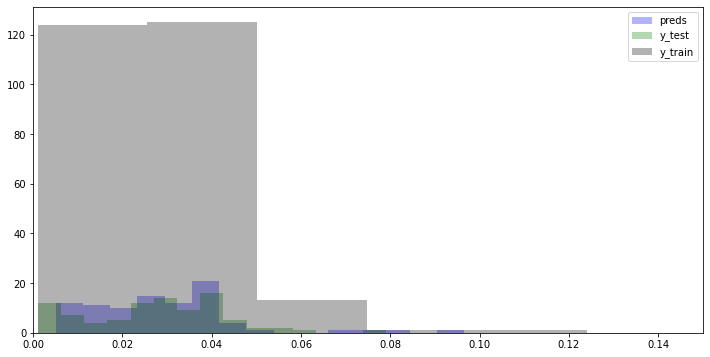

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(preds,   alpha=0.3,  bins = 15, color='blue' , label='preds')
plt.hist(y_test,  alpha=0.3,  bins = 15, color='green', label='y_test')
plt.hist(y_train, alpha=0.3,  bins = 15, color='black', label='y_train')

plt.legend()
plt.xlim((0,0.150))

In [ ]:
print('y_test:', np.median(y_test.flatten()))
print('pred:', np.median(preds.flatten()))
print('y_train:', np.median(y_train.flatten()))

y_test: 0.0295
pred: 0.027893474
y_train: 0.027999999999999997


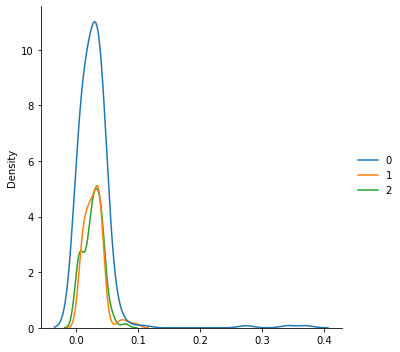

In [ ]:
sns.displot([y_train.flatten(), 
             preds.flatten(),
             y_test.flatten()], kind="kde")

(-0.5, 0.2)

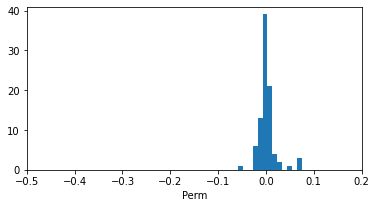

In [ ]:
error = preds.flatten() - y_test.flatten()

plt.figure(figsize=(6,3))
plt.hist(error, bins=13)
plt.xlabel('Perm')
plt.xlim((-.5,0.2))

In [ ]:
model1.feature_importances_

array([0.20686038, 0.0641271 , 0.17454794, 0.14698707, 0.        ,
       0.06403136, 0.07333025, 0.15235236, 0.05942161, 0.        ,
       0.05834194], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

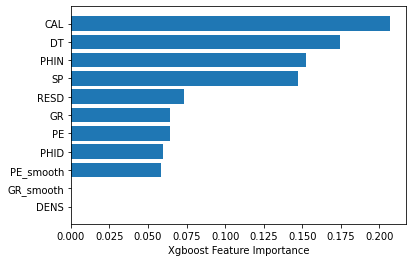

In [ ]:
sorted_idx = model1.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], model1.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")